In [1]:
# Imports
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
# Load train/test data
train_df = pd.read_csv(Path("../data/processed/train.csv"))
test_df = pd.read_csv(Path("../data/processed/test.csv"))

target_col = "dropout_risk"
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (480, 5)
Test shape: (120, 5)


In [3]:
# Define models
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}


In [4]:
# Define hyperparameter grids
param_grids = {
    "RandomForest": {
        "n_estimators": [100, 200, 500],
        "max_depth": [None, 5, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "GradientBoosting": {
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7]
    },
    "SVM": {
        "C": [0.1, 1, 10],
        "kernel": ["linear", "rbf"],
        "gamma": ["scale", "auto"]
    },
    "XGBoost": {
        "n_estimators": [100, 200],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    }
}


In [5]:
# Hyperparameter tuning and evaluation
tuned_models = {}
results = {}

for name, model in models.items():
    print(f"🔍 Tuning {name}...")
    param_grid = param_grids[name]
    
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=10,  # number of random combos
        scoring="accuracy",
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    search.fit(X_train, y_train)
    
    best_model = search.best_estimator_
    tuned_models[name] = best_model
    
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    results[name] = {
        "best_params": search.best_params_,
        "cv_best_score": search.best_score_,
        "test_acc": acc
    }
    
    print(f"✅ {name} Best Params: {search.best_params_}")
    print(f"CV Score: {search.best_score_:.3f}, Test Acc: {acc:.3f}\n")


🔍 Tuning RandomForest...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ RandomForest Best Params: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10}
CV Score: 0.998, Test Acc: 0.992

🔍 Tuning GradientBoosting...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ GradientBoosting Best Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01}
CV Score: 0.994, Test Acc: 0.992

🔍 Tuning SVM...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ SVM Best Params: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
CV Score: 0.990, Test Acc: 0.992

🔍 Tuning XGBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ XGBoost Best Params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
CV Score: 0.998, Test Acc: 1.000



c:\Users\Admin\Desktop\EduLensModelTraining\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:37:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                  Best CV Score  Test Accuracy
RandomForest           0.997917       0.991667
GradientBoosting       0.993750       0.991667
SVM                    0.989583       0.991667
XGBoost                0.997917       1.000000


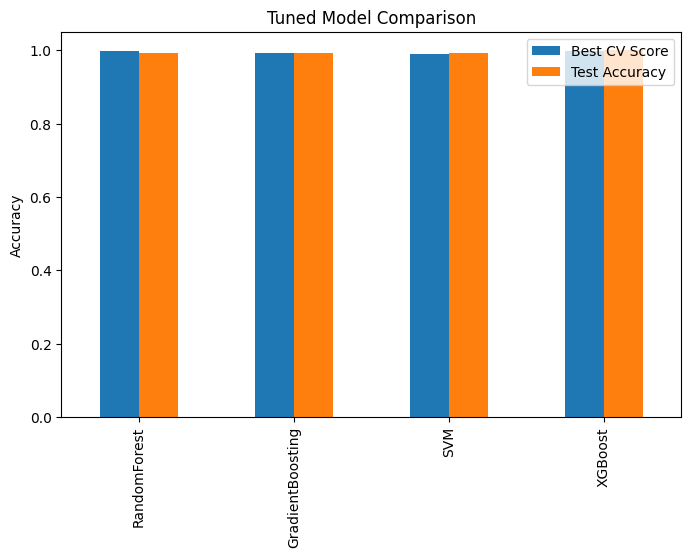

In [6]:
# Compare results
results_df = pd.DataFrame({
    model: [results[model]["cv_best_score"], results[model]["test_acc"]]
    for model in results
}, index=["Best CV Score", "Test Accuracy"]).T

print(results_df)

results_df.plot(kind="bar", figsize=(8,5))
plt.title("Tuned Model Comparison")
plt.ylabel("Accuracy")
plt.show()


In [7]:
# Save best model
best_model_name = results_df["Test Accuracy"].idxmax()
best_model = tuned_models[best_model_name]

model_path = Path(f"../models/{best_model_name.lower()}_tuned.pkl")
model_path.parent.mkdir(parents=True, exist_ok=True)
joblib.dump(best_model, model_path)

print(f"🏆 Best tuned model ({best_model_name}) saved to {model_path}")


🏆 Best tuned model (XGBoost) saved to ..\models\xgboost_tuned.pkl
